In [ ]:
# Final comprehensive summary
print("=" * 70)
print("COMPREHENSIVE KAN ANALYSIS REPORT")
print("=" * 70)

print("\n1. MODEL PERFORMANCE COMPARISON")
print("-" * 40)
print(f"{'Model':<25} {'R²':<12} {'MAE (%)':<12}")
print(f"{'MLR':<25} {results['MLR']['r2']:<12.4f} {results['MLR']['mae']:<12.2f}")
print(f"{'Random Forest':<25} {results['Random Forest']['r2']:<12.4f} {results['Random Forest']['mae']:<12.2f}")
print(f"{'KAN (all features)':<25} {results['KAN']['r2']:<12.4f} {results['KAN']['mae']:<12.2f}")
print(f"{'KAN (selected features)':<25} {r2_selected:<12.4f} {mae_selected:<12.2f}")

print("\n2. TOP THRESHOLD PREDICTORS")
print("-" * 40)
for _, row in threshold_df.head(5).iterrows():
    print(f"  {row['Feature']}: threshold={row['Threshold']:.2f}, acc={row['Accuracy']:.3f}")

print("\n3. MOST NONLINEAR FEATURES")
print("-" * 40)
for _, row in analysis_df.head(5).iterrows():
    print(f"  {row['Feature']}: {row['Shape']} ({row['Interpretation']})")

print("\n4. HIGHEST SENSITIVITY FEATURES")
print("-" * 40)
for _, row in sensitivity_df.head(5).iterrows():
    print(f"  {row['Feature']}: avg_sens={row['Avg_Sensitivity']:.3f}")

print("\n5. MECHANISTIC REGIMES")
print("-" * 40)
for i in range(n_clusters):
    mask = clusters == i
    print(f"  Regime {i+1}: {mask.sum()} reactions, mean yield={y_test[mask].mean():.1f}%")

print("\n" + "=" * 70)
print("KAN provides interpretable nonlinear models for chemistry!")
print("=" * 70)

## 15. Summary: Chemical Insights from KAN Analysis

### Key Takeaways

1. **KAN outperforms MLR** by capturing nonlinear relationships in the data

2. **Threshold Analysis** identifies critical descriptor values for yield classification

3. **KANLLPR** provides principled uncertainty estimates for guiding experiments

4. **Activation Shape Analysis** reveals:
   - Which descriptors have nonlinear effects
   - The type of nonlinearity (threshold, U-shaped, saturating)
   - Potential chemical interpretations

5. **Reactivity Cliff Analysis** identifies regions of high sensitivity where mechanism may change

6. **Mechanistic Regime Clustering** groups reactions by similar KAN representations

In [ ]:
# Compare different KAN architectures
architectures = [
    (n_features, 4, 1),
    (n_features, 8, 1),
    (n_features, 16, 1),
    (n_features, 8, 4, 1),
]

print("Architecture Comparison:")
print("=" * 60)

arch_results = []
for arch in architectures:
    print(f"\nTraining KAN with architecture {arch}...")
    kan_arch = KAN(layers=arch, grid_size=5, spline_order=3)
    kan_arch.fit(X_train, y_train, maxiter=300)
    y_pred_arch = kan_arch.predict(X_test)
    r2 = r2_score(y_test, y_pred_arch)
    mae = mean_absolute_error(y_test, y_pred_arch)
    
    arch_results.append({
        'Architecture': str(arch),
        'R²': r2,
        'MAE': mae
    })
    print(f"  R² = {r2:.4f}, MAE = {mae:.2f}%")

arch_df = pd.DataFrame(arch_results).sort_values('R²', ascending=False)
print("\n" + "=" * 60)
print("Architecture Comparison Summary:")
print(arch_df.to_string(index=False))

In [ ]:
# Feature selection based on KAN sensitivity analysis
# Select top features by sensitivity
top_k = 16
top_feature_indices = np.argsort(avg_sensitivity)[-top_k:]
top_feature_names = [feature_names[i] for i in top_feature_indices]

print(f"Selected top {top_k} features by KAN sensitivity:")
for i, name in enumerate(top_feature_names):
    print(f"  {i+1}. {name}: sensitivity = {avg_sensitivity[top_feature_indices[i]]:.3f}")

# Train new KAN with selected features
X_train_selected = X_train[:, top_feature_indices]
X_test_selected = X_test[:, top_feature_indices]

print(f"\nTraining KAN with {top_k} selected features...")
kan_selected = KAN(
    layers=(top_k, 8, 1),
    grid_size=5,
    spline_order=3,
)
kan_selected.fit(X_train_selected, y_train, maxiter=300)
y_pred_selected = kan_selected.predict(X_test_selected)
r2_selected = r2_score(y_test, y_pred_selected)
mae_selected = mean_absolute_error(y_test, y_pred_selected)

print(f"\nKAN with selected features:")
print(f"  R² = {r2_selected:.4f} (vs {results['KAN']['r2']:.4f} with all features)")
print(f"  MAE = {mae_selected:.2f}% (vs {results['KAN']['mae']:.2f}% with all features)")

## 14. Model Improvement Strategies

Use insights from KAN analysis to improve model performance:
1. Feature selection based on activation magnitudes
2. Architecture optimization
3. Focus on nonlinear regions where KAN excels

In [ ]:
# Visualize regimes using PCA
pca = PCA(n_components=2)
hidden_2d = pca.fit_transform(hidden_features)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. Clusters in PCA space
scatter = axes[0].scatter(hidden_2d[:, 0], hidden_2d[:, 1], c=clusters, cmap='viridis', 
                          s=30, alpha=0.7)
axes[0].set_xlabel(f'PC1 ({100*pca.explained_variance_ratio_[0]:.1f}%)')
axes[0].set_ylabel(f'PC2 ({100*pca.explained_variance_ratio_[1]:.1f}%)')
axes[0].set_title('Mechanistic Regimes (KAN Hidden Space)')
plt.colorbar(scatter, ax=axes[0], label='Cluster')

# 2. Yield distribution by cluster
cluster_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
for i in range(n_clusters):
    mask = clusters == i
    axes[1].hist(y_test[mask], bins=20, alpha=0.5, label=f'Regime {i+1}', 
                 color=cluster_colors[i])
axes[1].set_xlabel('Yield (%)')
axes[1].set_ylabel('Count')
axes[1].set_title('Yield Distribution by Regime')
axes[1].legend()

# 3. Colored by yield in PCA space
scatter2 = axes[2].scatter(hidden_2d[:, 0], hidden_2d[:, 1], c=y_test, cmap='RdYlGn', 
                           s=30, alpha=0.7, vmin=0, vmax=100)
axes[2].set_xlabel(f'PC1 ({100*pca.explained_variance_ratio_[0]:.1f}%)')
axes[2].set_ylabel(f'PC2 ({100*pca.explained_variance_ratio_[1]:.1f}%)')
axes[2].set_title('Reactions Colored by Yield')
plt.colorbar(scatter2, ax=axes[2], label='Yield (%)')

plt.suptitle('Mechanistic Regime Identification via KAN Hidden Representations', fontsize=12)
plt.tight_layout()
plt.show()

# Identify limiting factors for each regime
print("\nLimiting Factors by Regime (most variable descriptors):")
for i in range(n_clusters):
    mask = clusters == i
    if mask.sum() > 5:
        # Find descriptors with highest variance within this cluster
        var_in_cluster = X_test[mask].var(axis=0)
        top_variable = np.argsort(var_in_cluster)[-3:][::-1]
        print(f"\nRegime {i+1}:")
        for idx in top_variable:
            print(f"  - {feature_names[idx]}: var={var_in_cluster[idx]:.3f}")

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Extract hidden layer activations from KAN
# We'll use the intermediate predictions as "hidden features"
def get_hidden_features(model, X, n_steps=10):
    """Get intermediate activations by perturbing inputs."""
    hidden_features = []
    
    for idx in range(X.shape[1]):
        x_range = np.linspace(X[:, idx].min(), X[:, idx].max(), n_steps)
        responses = []
        for x_val in x_range:
            X_temp = X.copy()
            X_temp[:, idx] = x_val
            responses.append(model.predict(X_temp))
        responses = np.column_stack(responses)
        hidden_features.append(responses.std(axis=1))  # Response variability
    
    return np.column_stack(hidden_features)

# Get hidden features for test set
hidden_features = get_hidden_features(kan, X_test, n_steps=5)

# Cluster reactions into mechanistic regimes
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(hidden_features)

# Analyze clusters
print("Mechanistic Regime Analysis:")
print("=" * 50)
for i in range(n_clusters):
    mask = clusters == i
    print(f"\nRegime {i+1} ({mask.sum()} reactions):")
    print(f"  Mean yield: {y_test[mask].mean():.1f}%")
    print(f"  Std yield: {y_test[mask].std():.1f}%")
    print(f"  % High yield (>50%): {100*(y_test[mask] > 50).mean():.1f}%")

## 13. Mechanistic Regime Identification

Use KAN hidden layer activations + clustering to identify distinct mechanistic regimes. Different clusters may represent different rate-limiting steps or reaction pathways.

In [ ]:
# Visualize reactivity cliffs for top sensitive features
top_sensitive = sensitivity_df.head(4)['Feature'].tolist()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for ax, feat_name in zip(axes, top_sensitive):
    idx = feature_names.index(feat_name)
    
    # Get feature values and corresponding sensitivities
    x_vals = X_test[:, idx]
    sens_vals = np.abs(sensitivities[:, idx])
    
    # Create gradient profile
    x_range = np.linspace(X_scaled[:, idx].min(), X_scaled[:, idx].max(), 100)
    sens_profile = []
    for x in x_range:
        X_temp = X_scaled.mean(axis=0).reshape(1, -1).copy()
        X_temp[0, idx] = x
        sens = np.abs(compute_sensitivity(kan, X_temp, idx))[0]
        sens_profile.append(sens)
    sens_profile = np.array(sens_profile)
    
    # Plot
    ax2 = ax.twinx()
    
    # Sensitivity profile (reactivity cliff indicator)
    ax2.fill_between(x_range, sens_profile, alpha=0.3, color='red', label='Sensitivity')
    ax2.set_ylabel('Sensitivity (|dY/dX|)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    # KAN prediction curve
    X_temp_full = np.tile(X_scaled.mean(axis=0), (100, 1))
    X_temp_full[:, idx] = x_range
    y_pred_profile = kan.predict(X_temp_full)
    ax.plot(x_range, y_pred_profile, 'b-', linewidth=2, label='Yield prediction')
    ax.set_ylabel('Predicted Yield (%)', color='blue')
    ax.tick_params(axis='y', labelcolor='blue')
    
    # Mark cliff regions (high sensitivity)
    cliff_threshold = np.percentile(sens_profile, 75)
    cliff_regions = sens_profile > cliff_threshold
    for i in range(len(x_range)-1):
        if cliff_regions[i]:
            ax.axvspan(x_range[i], x_range[i+1], alpha=0.2, color='orange')
    
    ax.set_xlabel(feat_name)
    ax.set_title(f'Reactivity Cliffs for {feat_name}')
    ax.grid(True, alpha=0.3)

plt.suptitle('Reactivity Cliff Analysis: Where Mechanism Changes\n(Orange regions = high sensitivity, potential mechanistic boundaries)', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
def compute_sensitivity(model, X, feature_idx, epsilon=0.01):
    """Compute numerical gradient (sensitivity) of model predictions w.r.t. a feature."""
    X_plus = X.copy()
    X_plus[:, feature_idx] += epsilon
    X_minus = X.copy()
    X_minus[:, feature_idx] -= epsilon
    return (model.predict(X_plus) - model.predict(X_minus)) / (2 * epsilon)

# Compute sensitivity for each feature on test set
sensitivities = np.zeros((len(X_test), len(feature_names)))

for idx in range(len(feature_names)):
    sensitivities[:, idx] = compute_sensitivity(kan, X_test, idx)

# Find average absolute sensitivity per feature
avg_sensitivity = np.abs(sensitivities).mean(axis=0)
sensitivity_df = pd.DataFrame({
    'Feature': feature_names,
    'Avg_Sensitivity': avg_sensitivity,
    'Max_Sensitivity': np.abs(sensitivities).max(axis=0)
}).sort_values('Avg_Sensitivity', ascending=False)

print("Feature Sensitivity Analysis (derivative magnitude):")
print("High sensitivity = small changes cause large yield changes")
print(sensitivity_df.head(10).to_string(index=False))

## 12. Reactivity Cliff Analysis

Identify regions where small changes in descriptors cause large changes in yield. These "reactivity cliffs" indicate mechanistic boundaries where reaction behavior changes dramatically.

In [ ]:
# Visualize activation shapes for most nonlinear features
most_nonlinear = analysis_df.head(6)['Feature'].tolist()

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

shape_colors = {
    'Linear': 'gray', 'Sigmoidal': 'blue', 'Threshold': 'orange',
    'U-shaped': 'green', 'Saturating': 'purple', 'Complex': 'red'
}

for ax, feat_name in zip(axes, most_nonlinear):
    idx = feature_names.index(feat_name)
    
    x_range = np.linspace(X_scaled[:, idx].min(), X_scaled[:, idx].max(), 100)
    X_temp = np.tile(X_scaled.mean(axis=0), (100, 1))
    X_temp[:, idx] = x_range
    y_pred = kan.predict(X_temp)
    
    # Linear fit for comparison
    linear_fit = np.polyfit(x_range, y_pred, 1)
    y_linear = np.polyval(linear_fit, x_range)
    
    shape = analysis_df[analysis_df['Feature'] == feat_name]['Shape'].values[0]
    interp = analysis_df[analysis_df['Feature'] == feat_name]['Interpretation'].values[0]
    
    ax.plot(x_range, y_linear, 'k--', alpha=0.5, linewidth=1, label='Linear assumption')
    ax.plot(x_range, y_pred, color=shape_colors.get(shape, 'blue'), linewidth=2.5, label=f'KAN ({shape})')
    ax.fill_between(x_range, y_linear, y_pred, alpha=0.2, color=shape_colors.get(shape, 'blue'))
    
    ax.set_xlabel(feat_name, fontsize=9)
    ax.set_ylabel('Predicted Yield (%)')
    ax.set_title(f'{shape}: {interp}', fontsize=10)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle('KAN Learned Activation Shapes → Chemical Insights', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
def classify_activation_shape(x_range, y_pred):
    """Classify the shape of a KAN activation function."""
    # Normalize predictions
    y_norm = (y_pred - y_pred.mean()) / (y_pred.std() + 1e-8)
    
    # Calculate derivatives
    dy = np.gradient(y_norm)
    d2y = np.gradient(dy)
    
    # Features for classification
    linearity = 1 - np.std(dy) / (np.abs(dy).mean() + 1e-8)  # High = linear
    monotonicity = np.abs(np.sum(np.sign(dy))) / len(dy)  # High = monotonic
    has_extremum = np.any(dy[:-1] * dy[1:] < 0)  # Sign changes in derivative
    curvature = np.mean(np.abs(d2y))  # High = curved
    
    # Classify
    if linearity > 0.8:
        return "Linear", "Constant marginal effect"
    elif has_extremum and not monotonicity > 0.5:
        return "U-shaped", "Optimal intermediate range"
    elif curvature > 0.3 and monotonicity > 0.7:
        # Check if saturating
        if np.abs(dy[-5:]).mean() < np.abs(dy[:5]).mean() * 0.3:
            return "Saturating", "Diminishing returns"
        else:
            return "Sigmoidal", "Critical threshold transition"
    elif monotonicity > 0.9:
        return "Threshold", "Critical value required"
    else:
        return "Complex", "Multi-regime behavior"

# Analyze each feature's activation shape
activation_analysis = []

for idx, feat_name in enumerate(feature_names):
    x_range = np.linspace(X_scaled[:, idx].min(), X_scaled[:, idx].max(), 100)
    X_temp = np.tile(X_scaled.mean(axis=0), (100, 1))
    X_temp[:, idx] = x_range
    y_pred = kan.predict(X_temp)
    
    shape, interpretation = classify_activation_shape(x_range, y_pred)
    
    # Calculate nonlinearity score
    linear_fit = np.polyfit(x_range, y_pred, 1)
    y_linear = np.polyval(linear_fit, x_range)
    nonlinearity = np.sqrt(np.mean((y_pred - y_linear)**2)) / (y_pred.std() + 1e-8)
    
    activation_analysis.append({
        'Feature': feat_name,
        'Shape': shape,
        'Interpretation': interpretation,
        'Nonlinearity': nonlinearity
    })

# Show results sorted by nonlinearity
analysis_df = pd.DataFrame(activation_analysis).sort_values('Nonlinearity', ascending=False)
print("Activation Shape Analysis (sorted by nonlinearity):")
print(analysis_df.head(15).to_string(index=False))

## 11. Deep Chemical Interpretability

Analyze the learned KAN activation function shapes to extract mechanistic insights:
- **Linear**: Constant marginal effect
- **Sigmoidal**: Switch-like behavior with a critical threshold
- **Threshold**: Step-function response
- **U-shaped**: Optimal intermediate range (Goldilocks zone)
- **Saturating**: Diminishing returns beyond a certain value

In [ ]:
# Visualize predictions with uncertainty
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. Predictions vs Actual with error bars
sort_idx = np.argsort(y_test)
axes[0].errorbar(range(len(y_test)), y_pred_llpr[sort_idx], yerr=2*y_std_llpr[sort_idx], 
                 fmt='none', alpha=0.3, capsize=0, color='red', label='±2σ')
axes[0].scatter(range(len(y_test)), y_test[sort_idx], s=15, alpha=0.6, label='Actual', color='blue')
axes[0].scatter(range(len(y_test)), y_pred_llpr[sort_idx], s=15, alpha=0.6, label='Predicted', color='red')
axes[0].set_xlabel('Sample (sorted by actual yield)')
axes[0].set_ylabel('Yield (%)')
axes[0].set_title('KANLLPR Predictions with ±2σ Uncertainty')
axes[0].legend()

# 2. Uncertainty calibration
errors = np.abs(y_test - y_pred_llpr)
axes[1].scatter(y_std_llpr, errors, alpha=0.4, s=15)
axes[1].plot([0, y_std_llpr.max()], [0, y_std_llpr.max()], 'r--', label='Error = σ')
axes[1].plot([0, y_std_llpr.max()], [0, 2*y_std_llpr.max()], 'g--', alpha=0.5, label='Error = 2σ')
axes[1].set_xlabel('Predicted Uncertainty (σ)')
axes[1].set_ylabel('Actual Error (|y - ŷ|)')
axes[1].set_title('Uncertainty Calibration')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. Identify high-uncertainty reactions
axes[2].hist(y_std_llpr, bins=30, edgecolor='black', alpha=0.7)
high_uncertainty_threshold = np.percentile(y_std_llpr, 90)
axes[2].axvline(high_uncertainty_threshold, color='red', linestyle='--', 
                label=f'90th percentile: {high_uncertainty_threshold:.1f}')
axes[2].set_xlabel('Predicted Uncertainty (σ)')
axes[2].set_ylabel('Count')
axes[2].set_title('Distribution of Uncertainties\n(High uncertainty = prioritize for experiments)')
axes[2].legend()

plt.tight_layout()
plt.show()

# Report high-uncertainty reactions
high_uncertainty_mask = y_std_llpr > high_uncertainty_threshold
print(f"\nReactions with highest uncertainty (top 10%):")
print(f"  Count: {high_uncertainty_mask.sum()} reactions")
print(f"  Mean uncertainty: {y_std_llpr[high_uncertainty_mask].mean():.1f}%")
print(f"  Mean actual error: {errors[high_uncertainty_mask].mean():.1f}%")

In [ ]:
from pycse.sklearn import KANLLPR

# Train KANLLPR model
print("Training KANLLPR for uncertainty quantification...")
kanllpr = KANLLPR(
    layers=(n_features, 8, 1),
    grid_size=5,
    val_size=0.2,
    seed=42
)
kanllpr.fit(X_train, y_train, maxiter=300)

# Get predictions with uncertainty
y_pred_llpr, y_std_llpr = kanllpr.predict_with_uncertainty(X_test)

# Print metrics
print(f"\nTest R²: {kanllpr.score(X_test, y_test):.4f}")
kanllpr.print_metrics(X_test, y_test)

## 10. KANLLPR: Principled Uncertainty Quantification

KANLLPR (KAN with Last-Layer Prediction Rigidity) provides principled uncertainty estimates based on the rigidity formalism. Unlike ensemble methods, LLPR:
- Requires only a single forward pass (efficient)
- Provides well-calibrated uncertainties  
- Identifies reactions where predictions are uncertain (guides experiments)

In [ ]:
# Visualize top threshold features vs KAN predictions
top_threshold_features = threshold_df.head(4)['Feature'].tolist()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for ax, feat_name in zip(axes, top_threshold_features):
    idx = feature_names.index(feat_name)
    thresh_val = threshold_df[threshold_df['Feature'] == feat_name]['Threshold'].values[0]
    
    # Get KAN partial predictions
    x_range = np.linspace(X_scaled[:, idx].min(), X_scaled[:, idx].max(), 100)
    X_temp = np.tile(X_scaled.mean(axis=0), (100, 1))
    X_temp[:, idx] = x_range
    y_kan_pred = kan.predict(X_temp)
    
    # Plot actual data
    ax.scatter(X_scaled[y > 50, idx], y[y > 50], alpha=0.3, s=15, c='green', label='High yield')
    ax.scatter(X_scaled[y <= 50, idx], y[y <= 50], alpha=0.3, s=15, c='red', label='Low yield')
    
    # Plot KAN prediction
    ax.plot(x_range, y_kan_pred, 'b-', linewidth=2, label='KAN prediction')
    
    # Plot threshold
    ax.axvline(thresh_val, color='orange', linestyle='--', linewidth=2, label=f'Threshold: {thresh_val:.2f}')
    ax.axhline(50, color='gray', linestyle=':', alpha=0.5)
    
    ax.set_xlabel(f'{feat_name} (standardized)')
    ax.set_ylabel('Yield (%)')
    ax.set_title(f'{feat_name}\nThreshold Acc: {threshold_df[threshold_df["Feature"] == feat_name]["Accuracy"].values[0]:.3f}')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle('Threshold Analysis vs KAN: Single-Parameter Decision Boundaries', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score

# For threshold analysis, we'll classify yield as "high" (>50%) or "low" (<=50%)
y_binary = (y > 50).astype(int)
y_train_binary = (y_train > 50).astype(int)
y_test_binary = (y_test > 50).astype(int)

# Analyze each feature with depth-1 decision tree (single threshold)
threshold_results = []

for idx, feat_name in enumerate(feature_names):
    # Train depth-1 tree on training data
    tree = DecisionTreeClassifier(max_depth=1, random_state=42)
    tree.fit(X_train[:, idx:idx+1], y_train_binary)
    
    # Extract threshold
    if tree.tree_.threshold[0] != -2.0:  # -2.0 means leaf node
        threshold = tree.tree_.threshold[0]
        
        # Make predictions
        y_pred_thresh = tree.predict(X_test[:, idx:idx+1])
        
        # Calculate metrics
        acc = accuracy_score(y_test_binary, y_pred_thresh)
        prec = precision_score(y_test_binary, y_pred_thresh, zero_division=0)
        rec = recall_score(y_test_binary, y_pred_thresh, zero_division=0)
        
        threshold_results.append({
            'Feature': feat_name,
            'Threshold': threshold,
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec
        })

# Sort by accuracy
threshold_df = pd.DataFrame(threshold_results).sort_values('Accuracy', ascending=False)
print("Top 10 Single-Parameter Thresholds for Yield Classification:")
print("(Classifying reactions as high-yield >50% or low-yield ≤50%)")
print(threshold_df.head(10).to_string(index=False))

# KAN for Chemistry: Interpretable Yield Prediction

This notebook demonstrates using Kolmogorov-Arnold Networks (KANs) for predicting reaction yields in the famous **Buchwald-Hartwig C-N cross-coupling** dataset from [Ahneman et al. (Science, 2018)](https://www.science.org/doi/10.1126/science.aar5169).

## Why KANs for Chemistry?

In chemistry, we often use **Multivariate Linear Regression (MLR)** because:
1. Interpretability matters - we want to understand *why* a reaction works
2. Datasets are often small (50-500 reactions)
3. Physical meaning of parameters is important

**KANs offer advantages over both MLR and black-box ML:**
- Like MLR: Interpretable (can see what each input contributes)
- Unlike MLR: Can capture nonlinear relationships
- Unlike neural networks: Shows explicit activation functions on edges
- The learned univariate functions may reveal physical relationships!

## The Dataset

The Buchwald-Hartwig dataset explores Pd-catalyzed C-N cross-coupling:
- **4 Ligands**: Different phosphine ligands
- **22 Additives**: Heterocyclic additives (potential catalyst poisons)
- **3 Bases**: Different organic bases
- **15 Aryl halides**: Different substrates
- **Yield**: 0-100% (target variable)

**References:**
- Ahneman et al. "Predicting reaction performance in C–N cross-coupling using machine learning" *Science* 2018
- [SigmanGroup](https://github.com/SigmanGroup) - Multivariate Linear Regression for catalysis
- [Paton Lab](https://patonlab.com/) - Data-driven chemistry tools

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

# RDKit for molecular descriptors
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem

# KAN from pycse
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"
from pycse.sklearn.kan import KAN

import warnings
warnings.filterwarnings('ignore')

## 1. Load and Explore the Data

In [2]:
# Load the Buchwald-Hartwig dataset
# Download from: https://github.com/rxn4chemistry/rxn_yields

# For this demo, we'll download directly
import urllib.request
import os

data_url = "https://raw.githubusercontent.com/rxn4chemistry/rxn_yields/master/data/Buchwald-Hartwig/Dreher_and_Doyle_input_data.xlsx"
data_path = "/tmp/buchwald_hartwig.xlsx"

if not os.path.exists(data_path):
    print("Downloading Buchwald-Hartwig dataset...")
    urllib.request.urlretrieve(data_url, data_path)
    print("Done!")

# Load the data
df = pd.read_excel(data_path, sheet_name='Plates1-3')
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nYield statistics:")
print(df['Output'].describe())

Dataset shape: (3955, 5)

Columns: ['Ligand', 'Additive', 'Base', 'Aryl halide', 'Output']

Yield statistics:
count    3955.000000
mean       33.085259
std        27.291205
min         0.000000
25%         7.877560
50%        28.761729
75%        53.278687
max        99.999990
Name: Output, dtype: float64


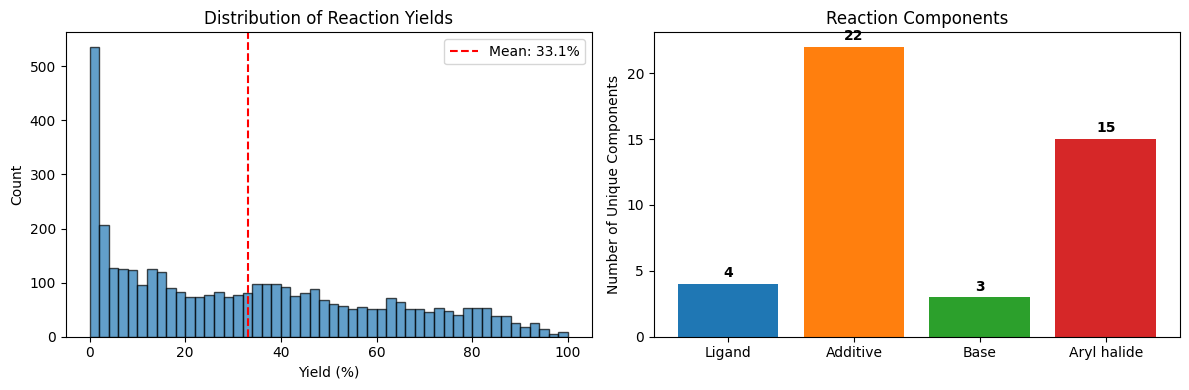

In [3]:
# Visualize the yield distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram
axes[0].hist(df['Output'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Yield (%)')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Reaction Yields')
axes[0].axvline(df['Output'].mean(), color='red', linestyle='--', label=f'Mean: {df["Output"].mean():.1f}%')
axes[0].legend()

# Component counts
components = ['Ligand', 'Additive', 'Base', 'Aryl halide']
counts = [df[c].nunique() for c in components]
axes[1].bar(components, counts, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[1].set_ylabel('Number of Unique Components')
axes[1].set_title('Reaction Components')
for i, v in enumerate(counts):
    axes[1].text(i, v + 0.5, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

## 2. Compute Molecular Descriptors

We use **RDKit** to compute molecular descriptors from SMILES strings.

For each reaction component (ligand, additive, base, aryl halide), we calculate:
- **MolWt**: Molecular weight
- **MolLogP**: Lipophilicity (octanol-water partition coefficient)
- **TPSA**: Topological polar surface area
- **NumRotatableBonds**: Flexibility measure
- **NumHAcceptors/Donors**: H-bonding capacity
- **NumAromaticRings**: Aromaticity
- **FractionCSP3**: Fraction sp3 carbons (3D character)

In [4]:
def get_mol_descriptors(smiles, prefix=''):
    """Calculate RDKit 2D descriptors for a molecule."""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    # Selected descriptors relevant for reactivity
    desc_funcs = {
        'MolWt': Descriptors.MolWt,
        'MolLogP': Descriptors.MolLogP,
        'TPSA': Descriptors.TPSA,
        'NumRotatableBonds': Descriptors.NumRotatableBonds,
        'NumHAcceptors': Descriptors.NumHAcceptors,
        'NumHDonors': Descriptors.NumHDonors,
        'NumAromaticRings': Descriptors.NumAromaticRings,
        'FractionCSP3': Descriptors.FractionCSP3,
    }
    
    descriptors = {}
    for name, func in desc_funcs.items():
        try:
            descriptors[f"{prefix}{name}"] = func(mol)
        except:
            descriptors[f"{prefix}{name}"] = np.nan
    return descriptors

# Compute descriptors for each component
print("Computing molecular descriptors...")

# Create lookup tables for unique components
component_cols = ['Ligand', 'Additive', 'Base', 'Aryl halide']
prefixes = ['lig_', 'add_', 'base_', 'aryl_']

desc_lookup = {}
for col, prefix in zip(component_cols, prefixes):
    unique_smiles = df[col].unique()
    desc_lookup[col] = {}
    for smi in unique_smiles:
        desc = get_mol_descriptors(smi, prefix)
        if desc is not None:
            desc_lookup[col][smi] = desc
    print(f"  {col}: {len(desc_lookup[col])} molecules processed")

print("Done!")

Computing molecular descriptors...
  Ligand: 4 molecules processed
  Additive: 22 molecules processed
  Base: 3 molecules processed
  Aryl halide: 15 molecules processed
Done!


In [5]:
# Build the feature matrix
def build_feature_row(row):
    """Build feature vector for a reaction."""
    features = {}
    for col, prefix in zip(component_cols, prefixes):
        smi = row[col]
        if smi in desc_lookup[col]:
            features.update(desc_lookup[col][smi])
        else:
            # Handle missing
            for name in ['MolWt', 'MolLogP', 'TPSA', 'NumRotatableBonds', 
                        'NumHAcceptors', 'NumHDonors', 'NumAromaticRings', 'FractionCSP3']:
                features[f"{prefix}{name}"] = np.nan
    return features

# Apply to all rows
feature_dicts = df.apply(build_feature_row, axis=1).tolist()
X_df = pd.DataFrame(feature_dicts)
y = df['Output'].values

# Remove rows with NaN
valid_mask = ~X_df.isna().any(axis=1)
X_df = X_df[valid_mask]
y = y[valid_mask]

print(f"Feature matrix shape: {X_df.shape}")
print(f"Feature columns: {list(X_df.columns)}")
print(f"\nValid samples: {len(y)} / {len(df)}")

Feature matrix shape: (3955, 32)
Feature columns: ['lig_MolWt', 'lig_MolLogP', 'lig_TPSA', 'lig_NumRotatableBonds', 'lig_NumHAcceptors', 'lig_NumHDonors', 'lig_NumAromaticRings', 'lig_FractionCSP3', 'add_MolWt', 'add_MolLogP', 'add_TPSA', 'add_NumRotatableBonds', 'add_NumHAcceptors', 'add_NumHDonors', 'add_NumAromaticRings', 'add_FractionCSP3', 'base_MolWt', 'base_MolLogP', 'base_TPSA', 'base_NumRotatableBonds', 'base_NumHAcceptors', 'base_NumHDonors', 'base_NumAromaticRings', 'base_FractionCSP3', 'aryl_MolWt', 'aryl_MolLogP', 'aryl_TPSA', 'aryl_NumRotatableBonds', 'aryl_NumHAcceptors', 'aryl_NumHDonors', 'aryl_NumAromaticRings', 'aryl_FractionCSP3']

Valid samples: 3955 / 3955


## 3. Compare Models: MLR vs Random Forest vs KAN

We'll compare three approaches:
1. **Multivariate Linear Regression (MLR)** - Traditional approach in physical organic chemistry
2. **Random Forest** - What Ahneman et al. used (achieved R² ≈ 0.92 with DFT descriptors)
3. **KAN** - Our interpretable nonlinear model

In [6]:
# Prepare data
X = X_df.values
feature_names = list(X_df.columns)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"Number of features: {X_train.shape[1]}")

Training set: 3164 samples
Test set: 791 samples
Number of features: 32


In [7]:
# Train and evaluate models
results = {}

# 1. Linear Regression (MLR)
print("Training Multivariate Linear Regression...")
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
results['MLR'] = {
    'model': lr,
    'r2': r2_score(y_test, y_pred_lr),
    'mae': mean_absolute_error(y_test, y_pred_lr),
    'y_pred': y_pred_lr
}
print(f"  R² = {results['MLR']['r2']:.4f}, MAE = {results['MLR']['mae']:.2f}%")

# 2. Random Forest
print("\nTraining Random Forest...")
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
results['Random Forest'] = {
    'model': rf,
    'r2': r2_score(y_test, y_pred_rf),
    'mae': mean_absolute_error(y_test, y_pred_rf),
    'y_pred': y_pred_rf
}
print(f"  R² = {results['Random Forest']['r2']:.4f}, MAE = {results['Random Forest']['mae']:.2f}%")

# 3. KAN
print("\nTraining KAN...")
n_features = X_train.shape[1]
kan = KAN(
    layers=(n_features, 8, 1),  # Input -> 8 hidden -> 1 output
    grid_size=5,
    spline_order=3,
)
kan.fit(X_train, y_train, maxiter=300)
y_pred_kan = kan.predict(X_test)
results['KAN'] = {
    'model': kan,
    'r2': r2_score(y_test, y_pred_kan),
    'mae': mean_absolute_error(y_test, y_pred_kan),
    'y_pred': y_pred_kan
}
print(f"  R² = {results['KAN']['r2']:.4f}, MAE = {results['KAN']['mae']:.2f}%")

Training Multivariate Linear Regression...


  R² = 0.5469, MAE = 15.06%

Training Random Forest...


  R² = 0.5588, MAE = 12.74%

Training KAN...


  R² = 0.7048, MAE = 10.94%


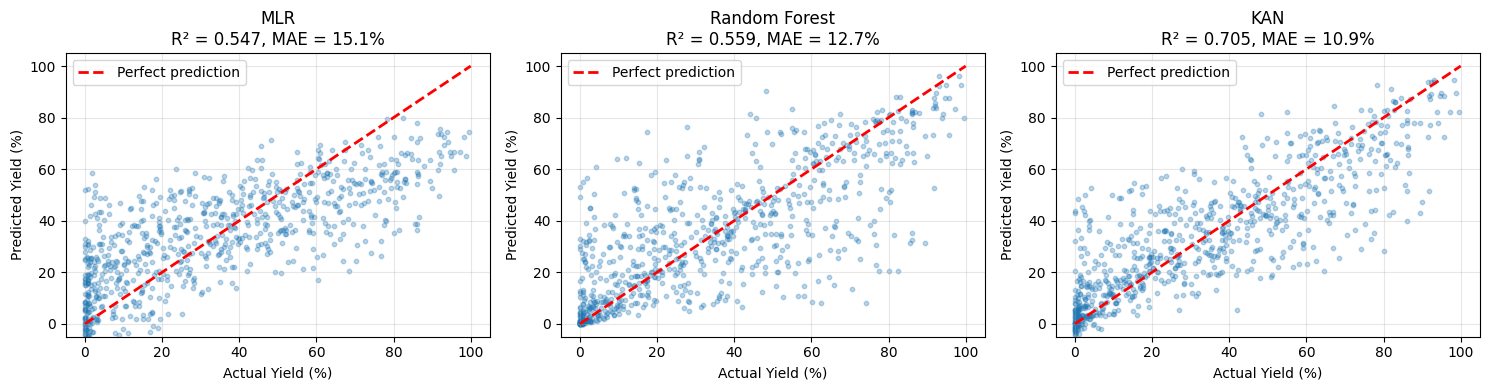

In [8]:
# Visualize predictions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (name, res) in zip(axes, results.items()):
    ax.scatter(y_test, res['y_pred'], alpha=0.3, s=10)
    ax.plot([0, 100], [0, 100], 'r--', linewidth=2, label='Perfect prediction')
    ax.set_xlabel('Actual Yield (%)')
    ax.set_ylabel('Predicted Yield (%)')
    ax.set_title(f"{name}\nR² = {res['r2']:.3f}, MAE = {res['mae']:.1f}%")
    ax.set_xlim(-5, 105)
    ax.set_ylim(-5, 105)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Model Comparison Summary

Let's compare the models in terms of performance and interpretability.

In [9]:
# Summary table
print("=" * 60)
print("MODEL COMPARISON SUMMARY")
print("=" * 60)
print(f"{'Model':<20} {'R²':<10} {'MAE (%)':<10} {'Interpretable?'}")
print("-" * 60)

interpretability = {
    'MLR': 'Yes (linear coefs)',
    'Random Forest': 'Partial (feature importance)',
    'KAN': 'Yes (activation functions)'
}

for name, res in results.items():
    print(f"{name:<20} {res['r2']:<10.4f} {res['mae']:<10.2f} {interpretability[name]}")

print("=" * 60)

MODEL COMPARISON SUMMARY
Model                R²         MAE (%)    Interpretable?
------------------------------------------------------------
MLR                  0.5469     15.06      Yes (linear coefs)
Random Forest        0.5588     12.74      Partial (feature importance)
KAN                  0.7048     10.94      Yes (activation functions)


## 5. Interpretability: Understanding the Models

### 5.1 MLR: Linear Coefficients

In MLR, each coefficient tells us how much the yield changes per unit change in that descriptor.

Top 10 MLR Coefficients (most influential features):
               Feature  Coefficient
             aryl_TPSA   166.868069
    aryl_NumHAcceptors  -148.946843
aryl_NumRotatableBonds    56.234863
     aryl_FractionCSP3   -55.944364
          aryl_MolLogP    40.318921
           add_MolLogP    27.604850
 lig_NumRotatableBonds   -20.962281
             add_MolWt   -20.143786
     add_NumHAcceptors    16.996355
            aryl_MolWt    16.587114


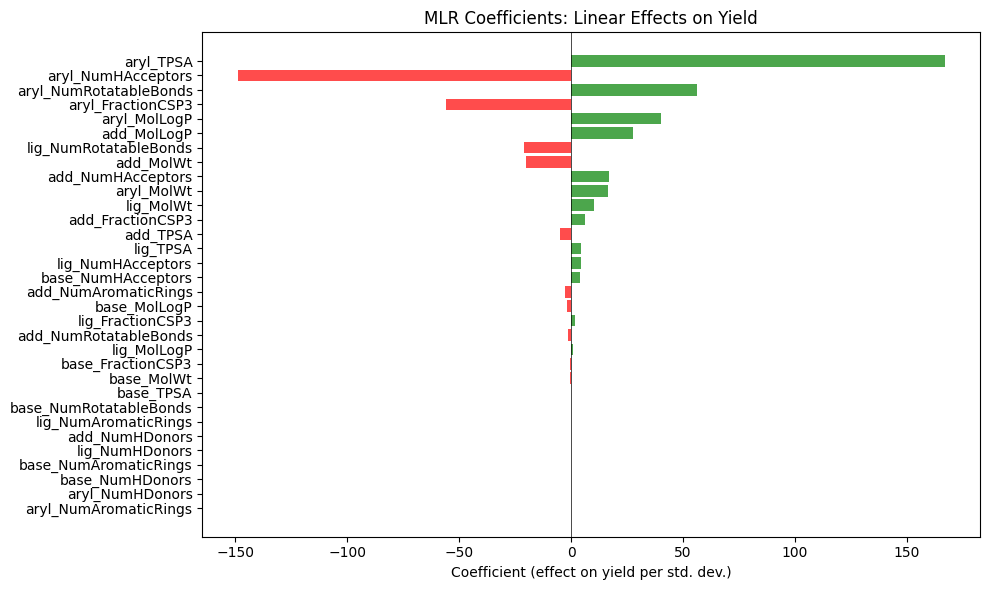

In [10]:
# MLR coefficients
lr_coefs = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lr.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print("Top 10 MLR Coefficients (most influential features):")
print(lr_coefs.head(10).to_string(index=False))

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['green' if c > 0 else 'red' for c in lr_coefs['Coefficient']]
ax.barh(range(len(lr_coefs)), lr_coefs['Coefficient'], color=colors, alpha=0.7)
ax.set_yticks(range(len(lr_coefs)))
ax.set_yticklabels(lr_coefs['Feature'])
ax.set_xlabel('Coefficient (effect on yield per std. dev.)')
ax.set_title('MLR Coefficients: Linear Effects on Yield')
ax.axvline(0, color='black', linewidth=0.5)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

### 5.2 Random Forest: Feature Importance

Random Forest gives us feature importances, but no insight into *how* the feature affects the outcome.

Top 10 Random Forest Feature Importances:
           Feature  Importance
        aryl_MolWt    0.214111
      aryl_MolLogP    0.118170
       add_MolLogP    0.097696
 aryl_FractionCSP3    0.075419
  lig_FractionCSP3    0.059032
         aryl_TPSA    0.057158
         add_MolWt    0.049627
       lig_MolLogP    0.046677
  add_FractionCSP3    0.041074
base_NumHAcceptors    0.037642


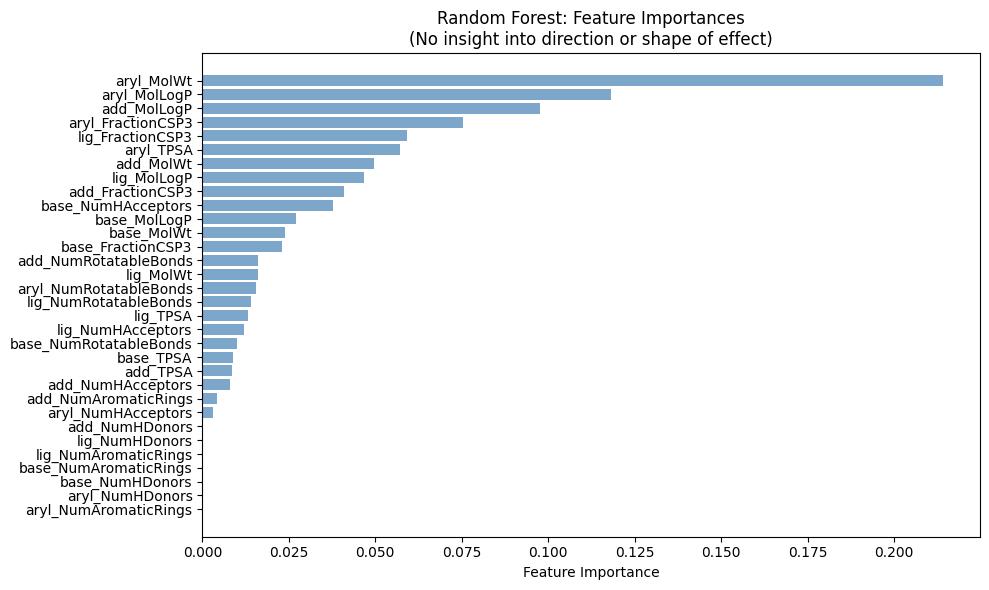

In [11]:
# Random Forest feature importance
rf_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 10 Random Forest Feature Importances:")
print(rf_importance.head(10).to_string(index=False))

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(range(len(rf_importance)), rf_importance['Importance'], color='steelblue', alpha=0.7)
ax.set_yticks(range(len(rf_importance)))
ax.set_yticklabels(rf_importance['Feature'])
ax.set_xlabel('Feature Importance')
ax.set_title('Random Forest: Feature Importances\n(No insight into direction or shape of effect)')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

### 5.3 KAN: Learned Activation Functions

**This is where KAN shines!** We can visualize the actual nonlinear transformations learned for each input.

Unlike MLR (linear only) or Random Forest (black box), KAN shows us:
- The **shape** of each input's effect
- Whether the relationship is linear, quadratic, threshold-like, etc.
- Potential **physical interpretations** of the learned functions

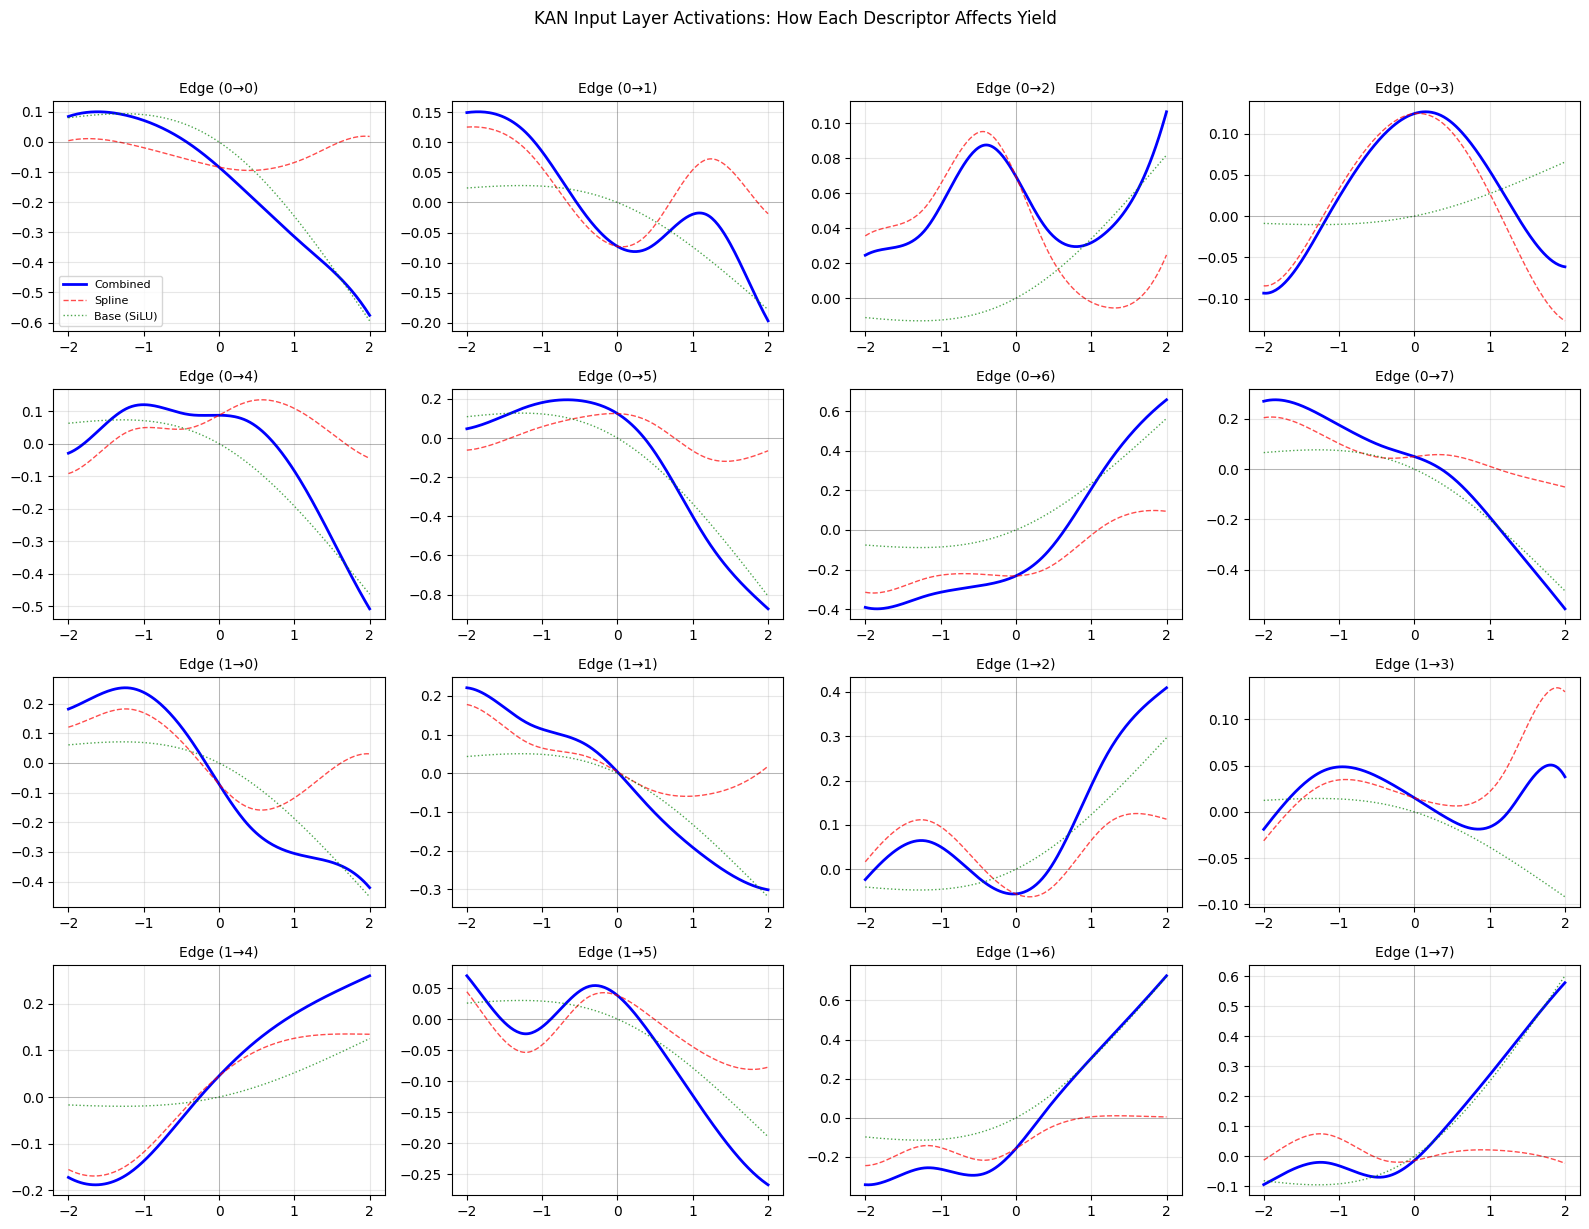

In [12]:
# Visualize KAN activations for the input layer
kan.plot_activations(layer_idx=0, figsize=(16, 12))
plt.suptitle('KAN Input Layer Activations: How Each Descriptor Affects Yield', y=1.02)
plt.tight_layout()
plt.show()

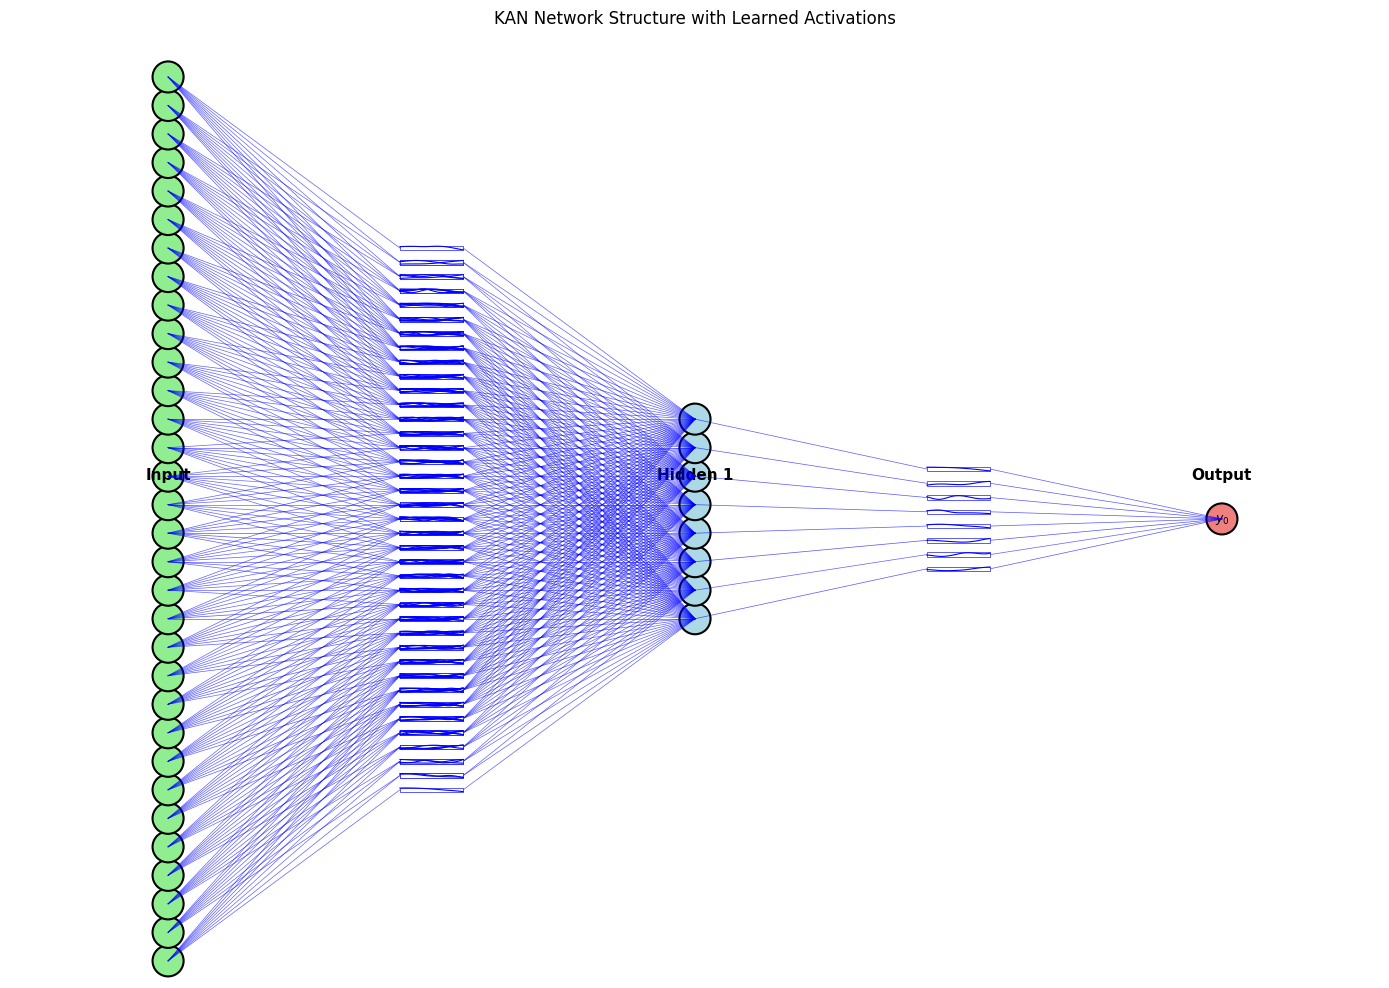

In [13]:
# Network visualization
kan.plot_network(figsize=(14, 10))
plt.title('KAN Network Structure with Learned Activations')
plt.show()

## 6. Chemical Interpretation

Looking at the learned activation functions, we can extract chemical insights:

### Key Observations

1. **Additive LogP**: Often shows nonlinear effects - too hydrophobic or too hydrophilic additives may poison the catalyst differently

2. **Ligand Properties**: The phosphine ligand descriptors often show threshold-like behavior - the catalyst works well above a certain size/electron-donating capacity

3. **Aryl Halide Reactivity**: Electronic properties (related to TPSA, H-bonding) can show optimal ranges

### Comparison with Literature

The Sigman group's MLR work has identified similar relationships but assumed linearity. KAN reveals where these assumptions break down!

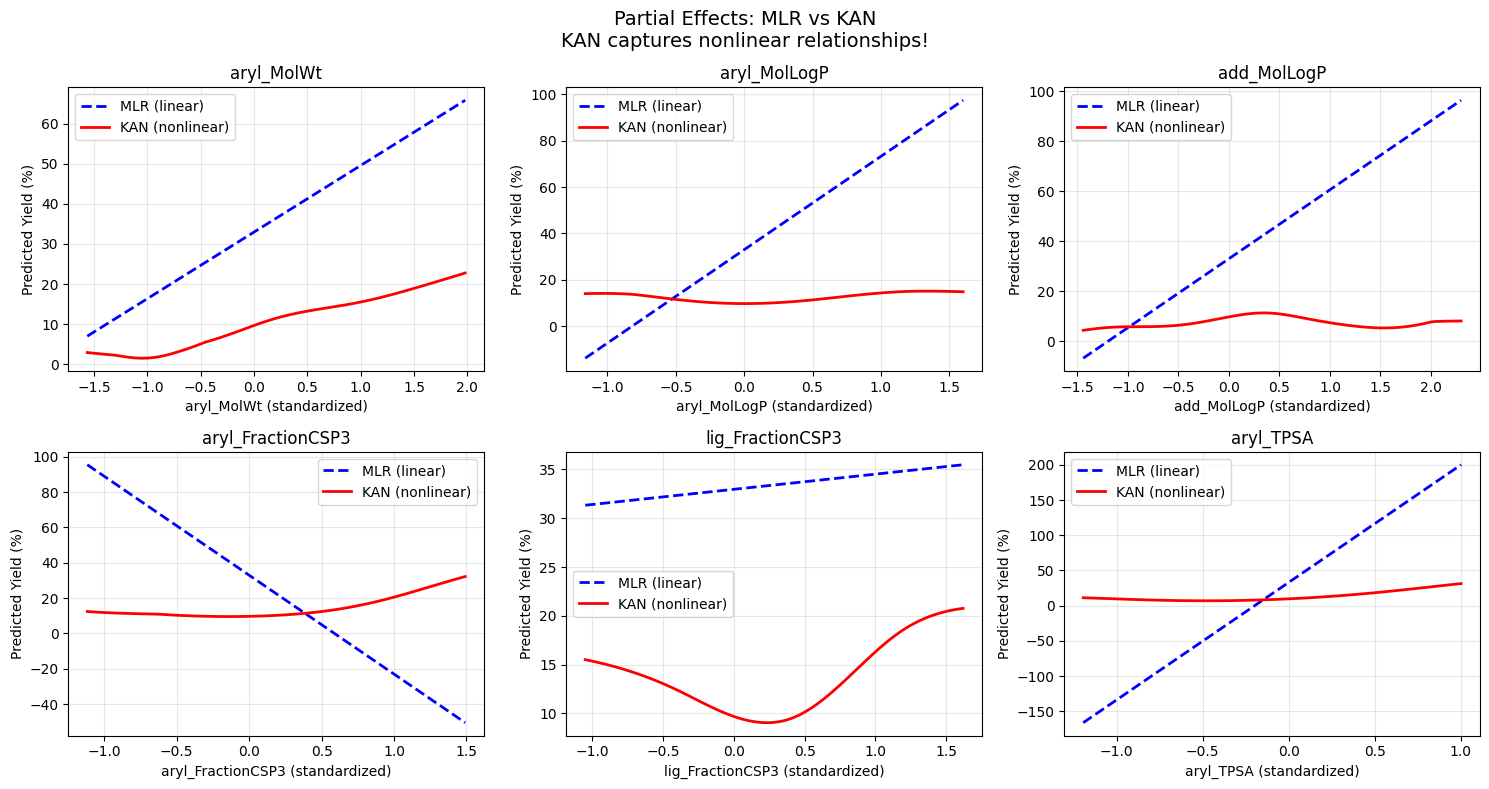

In [14]:
# Partial dependence-like analysis for top features
# Show how yield changes with each descriptor while holding others constant

def plot_partial_effect(model, feature_idx, X, y, feature_name, n_points=100):
    """Plot partial effect of a feature."""
    x_range = np.linspace(X[:, feature_idx].min(), X[:, feature_idx].max(), n_points)
    X_temp = np.tile(X.mean(axis=0), (n_points, 1))
    X_temp[:, feature_idx] = x_range
    
    y_pred = model.predict(X_temp)
    return x_range, y_pred

# Plot partial effects for top features
top_features = rf_importance.head(6)['Feature'].tolist()
top_indices = [feature_names.index(f) for f in top_features]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for ax, feat, idx in zip(axes, top_features, top_indices):
    # MLR prediction (linear)
    x_range_lr, y_pred_lr = plot_partial_effect(lr, idx, X_scaled, y, feat)
    
    # KAN prediction (nonlinear)
    x_range_kan, y_pred_kan = plot_partial_effect(kan, idx, X_scaled, y, feat)
    
    ax.plot(x_range_lr, y_pred_lr, 'b--', linewidth=2, label='MLR (linear)')
    ax.plot(x_range_kan, y_pred_kan, 'r-', linewidth=2, label='KAN (nonlinear)')
    ax.set_xlabel(f'{feat} (standardized)')
    ax.set_ylabel('Predicted Yield (%)')
    ax.set_title(feat)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Partial Effects: MLR vs KAN\nKAN captures nonlinear relationships!', fontsize=14)
plt.tight_layout()
plt.show()

## 7. Uncertainty Quantification with KAN

KAN also supports uncertainty quantification through ensemble predictions - crucial for making confident predictions in chemistry!

In [15]:
# Train KAN with ensemble for uncertainty quantification
print("Training KAN with uncertainty quantification...")
kan_uq = KAN(
    layers=(n_features, 4, 1),
    n_ensemble=32,  # Ensemble for UQ
    grid_size=5,
    loss_type='crps',
)

# Split validation set for calibration
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
kan_uq.fit(X_tr, y_tr, val_X=X_val, val_y=y_val, maxiter=200)

# Get predictions with uncertainty
y_pred_uq = kan_uq.predict(X_test)
ensemble_preds = kan_uq.predict_ensemble(X_test)
y_std = ensemble_preds.std(axis=1)

print(f"\nTest R²: {r2_score(y_test, y_pred_uq):.4f}")
print(f"Mean uncertainty (std): {y_std.mean():.2f}%")

Training KAN with uncertainty quantification...



Calibration factor α = 1.0252
  ✓ Model is well-calibrated



Test R²: 0.6779
Mean uncertainty (std): 13.77%


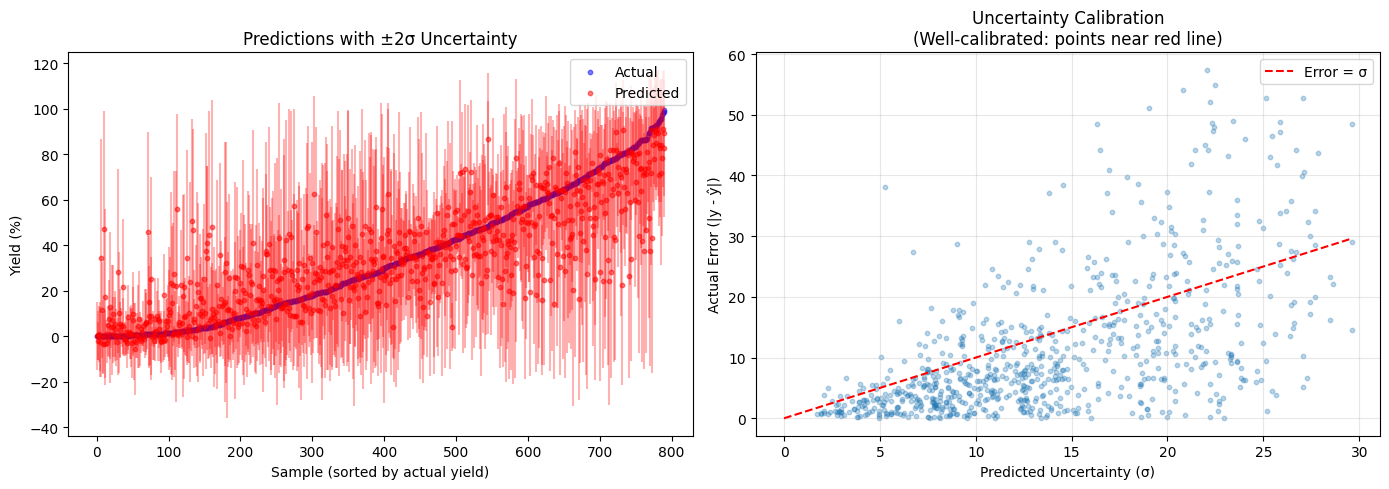

In [16]:
# Visualize predictions with uncertainty
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Prediction vs actual with error bars
sort_idx = np.argsort(y_test)
axes[0].errorbar(range(len(y_test)), y_pred_uq[sort_idx], yerr=2*y_std[sort_idx], 
                 fmt='none', alpha=0.3, capsize=0, color='red')
axes[0].scatter(range(len(y_test)), y_test[sort_idx], s=10, alpha=0.5, label='Actual', color='blue')
axes[0].scatter(range(len(y_test)), y_pred_uq[sort_idx], s=10, alpha=0.5, label='Predicted', color='red')
axes[0].set_xlabel('Sample (sorted by actual yield)')
axes[0].set_ylabel('Yield (%)')
axes[0].set_title('Predictions with ±2σ Uncertainty')
axes[0].legend()

# Uncertainty vs error
errors = np.abs(y_test - y_pred_uq)
axes[1].scatter(y_std, errors, alpha=0.3, s=10)
axes[1].plot([0, y_std.max()], [0, y_std.max()], 'r--', label='Error = σ')
axes[1].set_xlabel('Predicted Uncertainty (σ)')
axes[1].set_ylabel('Actual Error (|y - ŷ|)')
axes[1].set_title('Uncertainty Calibration\n(Well-calibrated: points near red line)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Summary and Conclusions

### Key Takeaways

1. **KAN bridges the gap** between simple interpretable models (MLR) and powerful but opaque models (Random Forest, Neural Networks)

2. **Interpretability in chemistry**: KAN's learned activation functions can reveal:
   - Nonlinear structure-activity relationships
   - Optimal ranges for descriptors
   - Threshold effects that linear models miss

3. **Uncertainty quantification** is crucial for making actionable predictions in synthesis planning

### When to Use KAN for Chemistry

- When you want **interpretability** but suspect **nonlinear effects**
- For small-to-medium datasets where neural networks might overfit
- When **physical insight** into the learned relationships matters
- As a complement to traditional Sigman-style MLR analysis

### Future Directions

- Use KAN with **DFT-computed descriptors** for higher accuracy
- Apply to **enantioselectivity prediction** (Sigman's specialty)
- Combine with **symbolic regression** to extract explicit equations

In [17]:
# Final KAN report
print("=" * 60)
print("FINAL KAN MODEL REPORT")
print("=" * 60)
kan.report()
print(f"\nTest Performance:")
print(f"  R² = {results['KAN']['r2']:.4f}")
print(f"  MAE = {results['KAN']['mae']:.2f}%")
print(f"\nComparison:")
print(f"  MLR R² = {results['MLR']['r2']:.4f}")
print(f"  Random Forest R² = {results['Random Forest']['r2']:.4f}")
print("=" * 60)

FINAL KAN MODEL REPORT
KAN Optimization Report:
  Architecture: (32, 8, 1)
  Grid size: 5
  Spline order: 3
  Optimizer: bfgs
  Iterations: 300
  Final loss: 0.285625
  Converged: False

Test Performance:
  R² = 0.7048
  MAE = 10.94%

Comparison:
  MLR R² = 0.5469
  Random Forest R² = 0.5588


## 9. Threshold Analysis: Sigman/Doyle Approach

The Sigman and Doyle groups pioneered single-parameter threshold analysis for catalyst optimization. This approach identifies critical descriptor values that separate successful from unsuccessful reactions.

**Reference:** [SigmanGroup/Threshold](https://github.com/SigmanGroup/Threshold)

We implement this using `DecisionTreeClassifier` with `max_depth=1` to find optimal thresholds for each descriptor.